<a href="https://colab.research.google.com/github/mobarakol/SVLS/blob/main/SVLS_Interactive_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatially Varying Label Smoothing: Capturing Uncertainty from Expert Annotations
[Preprint](https://arxiv.org/pdf/2104.05788.pdf)
[Code](https://github.com/mobarakol/SVLS)

Downloading SVLS and Surface Dice codes

In [1]:
!rm -rf SVLS
!git clone https://github.com/mobarakol/SVLS.git
%cd SVLS
!git clone https://github.com/deepmind/surface-distance.git
!mv surface-distance surface_distance

Cloning into 'SVLS'...
remote: Enumerating objects: 394, done.
remote: Counting objects: 100% (394/394), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 394 (delta 348), reused 372 (delta 336), pack-reused 0
Receiving objects: 100% (394/394), 66.33 KiB | 2.76 MiB/s, done.
Resolving deltas: 100% (348/348), done.
/content/SVLS
Cloning into 'surface-distance'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 50 (delta 11), reused 8 (delta 7), pack-reused 33
Unpacking objects: 100% (50/50), 36.65 KiB | 1.18 MiB/s, done.


Install require packages:

In [2]:
!pip install -U -q SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.0 MB/s eta 0:00:00


### Download Dataset and Trained Models

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Trained Models: https://drive.google.com/file/d/1evE2VqBGdY-0VPB8OeArHMPdRXhWuxFm/view?usp=sharing <br>
Validation Data: https://drive.google.com/file/d/1oZ9z-l9lBjKGNZCCTK819Z1ufwe90mg3/view?usp=sharing

In [6]:
ids = ['1evE2VqBGdY-0VPB8OeArHMPdRXhWuxFm', '1oZ9z-l9lBjKGNZCCTK819Z1ufwe90mg3']
zip_files = ['ckpt_brats19.zip','train_valid.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id})
    downloaded.GetContentFile(zip_file)
    !unzip -q $zip_file

Demo

valid sample: 66 valid minibatch: 33
model:best_oh.pth.tar , dice[ET:0.802 ± 0.179, TC:0.861 ± 0.128, WT:0.892 ± 0.074], ECE:0.0768, TACE:0.0041
model:best_oh.pth.tar , Surface dice[ET:0.916 ± 0.196, TC:0.862 ± 0.181, WT:0.894 ± 0.147]
model:best_ls0.1.pth.tar , dice[ET:0.825 ± 0.152, TC:0.873 ± 0.131, WT:0.892 ± 0.071], ECE:0.0659, TACE:0.0025
model:best_ls0.1.pth.tar , Surface dice[ET:0.933 ± 0.169, TC:0.888 ± 0.175, WT:0.911 ± 0.121]
model:best_ls0.2.pth.tar , dice[ET:0.819 ± 0.148, TC:0.861 ± 0.135, WT:0.892 ± 0.070], ECE:0.0931, TACE:0.0049
model:best_ls0.2.pth.tar , Surface dice[ET:0.929 ± 0.185, TC:0.879 ± 0.183, WT:0.906 ± 0.127]
model:best_ls0.3.pth.tar , dice[ET:0.788 ± 0.209, TC:0.858 ± 0.161, WT:0.891 ± 0.072], ECE:0.1467, TACE:0.0073
model:best_ls0.3.pth.tar , Surface dice[ET:0.914 ± 0.195, TC:0.873 ± 0.188, WT:0.919 ± 0.113]
model:best_svls.pth.tar , dice[ET:0.817 ± 0.138, TC:0.864 ± 0.118, WT:0.895 ± 0.064], ECE:0.0614, TACE:0.0040
model:best_svls.pth.tar , Surface dice[

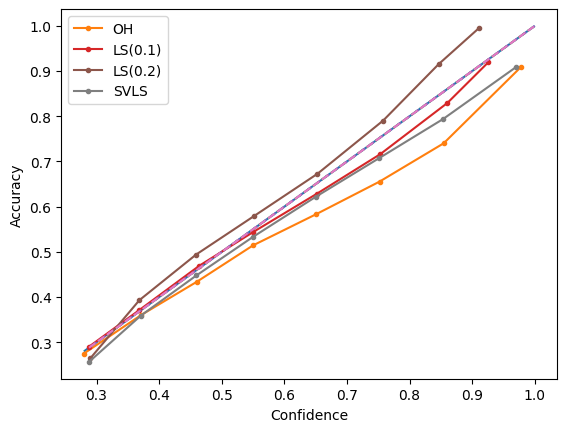

In [15]:
import argparse
import os
import numpy as np
import pathlib
import torch
from torch.nn import functional as F
from model import UNet3D
from datasets import get_datasets_brats
from utils import seed_everything, EDiceLoss
from calibration_metrics import ece_eval, tace_eval, reliability_diagram
import warnings
warnings.filterwarnings("ignore")

def step_valid(data_loader, model, metric):
    ece_all, acc_all, conf_all, tace_all = [], [], [], []
    losses, metrics, metrics_sd = [], [], []
    model.eval()
    for i, batch in enumerate(data_loader):
        targets = batch["label"].squeeze(1).cuda(non_blocking=True)
        inputs = batch["image"].float().cuda()
        segs = model(inputs)
        outputs = F.softmax(segs, dim=1).detach().cpu().numpy()
        if len(targets.shape) < 4:#if batch size=1
            targets = targets.unsqueeze(0)
        labels = targets.detach().cpu().numpy()

        ece, acc, conf, _ = ece_eval(outputs,labels)
        tace, _, _, _ = tace_eval(outputs,labels)
        ece_all.append(ece)
        acc_all.append(acc)
        conf_all.append(conf)
        tace_all.append(tace)
        segs = segs.data.max(1)[1].squeeze_(1)
        metric_ = metric.metric_brats(segs, targets)
        metrics_sd.extend(metric.get_surface_dice(segs.detach().cpu().numpy(), targets.detach().cpu().numpy()))
        metrics.extend(metric_)

    ece_avg = np.stack(ece_all).mean(0)
    acc_avg = np.stack(acc_all).mean(0)
    conf_avg = np.stack(conf_all).mean(0)
    tace_avg = np.stack(tace_all).mean(0)
    return metrics, metrics_sd, ece_avg, acc_avg, conf_avg, tace_avg

def main():
    parser = argparse.ArgumentParser(description='SVLS Brats Training')
    parser.add_argument('--batch_size', default=2, type=int,help='mini-batch size')
    parser.add_argument('--num_classes', default=4, type=int, help="num of classes")
    parser.add_argument('--in_channels', default=4, type=int, help="num of input channels")
    parser.add_argument('--train_option', default='SVLS', help="options:[SVLS, LS, OH]")
    parser.add_argument('--epochs', default=200, type=int, help='number of total epochs to run')
    parser.add_argument('--data_root', default='train_valid', help='data directory')
    parser.add_argument('--ckpt_dir', default='ckpt_brats19', help='ckpt directory')
    args = parser.parse_args(args=[])

    _, val_dataset = get_datasets_brats(data_root=args.data_root)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
        pin_memory=False, num_workers=2)

    print('valid sample:',len(val_dataset), 'valid minibatch:',len(val_loader))

    model = UNet3D(inplanes=args.in_channels, num_classes=args.num_classes).cuda()

    model = torch.nn.DataParallel(model)
    criterion_dice = EDiceLoss().cuda()

    legends = ['OH', 'LS(0.1)', 'LS(0.2)', 'LS(0.3)', 'SVLS']
    model_list = ['best_oh.pth.tar', 'best_ls0.1.pth.tar', 'best_ls0.2.pth.tar', 'best_ls0.3.pth.tar', 'best_svls.pth.tar']
    for model_name, legend in zip(model_list, legends):
        model.load_state_dict(torch.load(os.path.join(args.ckpt_dir, model_name)))
        model.eval()
        with torch.no_grad():
            dice_metrics, metrics_sd, ece_avg, acc_avg, conf_avg, tace_avg = step_valid(val_loader, model, criterion_dice)
        if legend != 'LS(0.3)':
            reliability_diagram(conf_avg, acc_avg, legend=legend)
        dice_metrics = list(zip(*dice_metrics))
        dice_metrics = [torch.tensor(dice, device="cpu").numpy() for dice in dice_metrics]
        avg_dices = np.mean(dice_metrics,1)
        avg_std = np.std(dice_metrics,1)

        metrics_sd = list(zip(*metrics_sd))
        metrics_sd = [torch.tensor(dice, device="cpu").numpy() for dice in metrics_sd]
        avg_sd = np.mean(metrics_sd,1)
        avg_std_sd = np.std(metrics_sd,1)

        print('model:%s , dice[ET:%.3f ± %.3f, TC:%.3f ± %.3f, WT:%.3f ± %.3f], ECE:%.4f, TACE:%.4f'%(
            model_name, avg_dices[0],avg_std[0], avg_dices[1],avg_std[1], avg_dices[2],avg_std[2], ece_avg, tace_avg))

        print('model:%s , Surface dice[ET:%.3f ± %.3f, TC:%.3f ± %.3f, WT:%.3f ± %.3f]'%(
            model_name, avg_sd[0],avg_std_sd[0], avg_sd[1],avg_std_sd[1], avg_sd[2],avg_std_sd[2]))

if __name__ == '__main__':
    seed_everything()
    main()


Saving the prediction: same size as training

In [74]:
import argparse
import os
import numpy as np
import pathlib
import torch
from torch.nn import functional as F
from model import UNet3D
from datasets import get_datasets_brats
from utils import seed_everything, EDiceLoss
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import random
from glob import glob
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.utils.data._utils.collate import default_collate
from datasets import custom_collate, determinist_collate, pad_batch_to_max_shape, \
pad_batch1_to_compatible_size, irm_min_max_preprocess, pad_or_crop_image

import warnings
warnings.filterwarnings("ignore")


parser = argparse.ArgumentParser(description='SVLS Brats Training')
parser.add_argument('--batch_size', default=2, type=int,help='mini-batch size')
parser.add_argument('--num_classes', default=4, type=int, help="num of classes")
parser.add_argument('--in_channels', default=4, type=int, help="num of input channels")
parser.add_argument('--train_option', default='SVLS', help="options:[SVLS, LS, OH]")
parser.add_argument('--epochs', default=200, type=int, help='number of total epochs to run')
parser.add_argument('--data_root', default='train_valid', help='data directory')
parser.add_argument('--ckpt_dir', default='ckpt_brats19', help='ckpt directory')
args = parser.parse_args(args=[])

def get_datasets_brats(data_root=None, normalisation="zscore"):

    data_root = pathlib.Path(data_root)
    base_folder_train = pathlib.Path('data/BraTS19/train_train/').resolve()
    base_folder_valid = pathlib.Path('data/BraTS19/train_valid/').resolve()
    patients_dir_train = sorted([data_root/x.name for x in base_folder_train.iterdir() if (data_root/x.name).is_dir()])
    patients_dir_valid = sorted([data_root/x.name for x in base_folder_valid.iterdir() if (data_root/x.name).is_dir()])
    train_dataset = brats19(patients_dir_train, training=True, normalisation=normalisation)
    val_dataset = brats19(patients_dir_valid, training=False, normalisation=normalisation)
    return train_dataset, val_dataset


class brats19(Dataset):
    def __init__(self, patients_dir, training=True, no_seg=False, normalisation="minmax"):
        super(brats19, self).__init__()
        self.normalisation = normalisation
        self.training = training
        self.datas = []
        self.validation = no_seg
        self.patterns = [ "_flair", "_t1", "_t1ce", "_t2"]
        self.mean = dict(flair=0.0860377, t1=0.1216296, t1ce=0.07420689, t2=0.09033176)
        if not no_seg:
            self.patterns += ["_seg"]
        for patient_dir in patients_dir:
            patient_id = patient_dir.name
            paths = [patient_dir / f"{patient_id}{value}.nii.gz" for value in self.patterns]
            patient = dict(
                id=patient_id, flair=paths[0], t1=paths[1], t1ce=paths[2],
                t2=paths[3], seg=paths[4] if not no_seg else None
            )
            self.datas.append(patient)

    def __getitem__(self, idx):
        _patient = self.datas[idx]
        patient_image = {key: self.load_nii(_patient[key]) for key in _patient if key not in ["id", "seg"]}
        if _patient["seg"] is not None:
            patient_label = self.load_nii(_patient["seg"])

        patient_image = {key: (irm_min_max_preprocess(patient_image[key]) - self.mean[key]) for key in patient_image}
        patient_image = np.stack([patient_image[key] for key in patient_image])
        patient_label[patient_label==4] = 3
        patient_label = patient_label[None,:,:,:]

        # Remove maximum extent of the zero-background to make future crop more useful
        z_indexes, y_indexes, x_indexes = np.nonzero(np.sum(patient_image, axis=0) != 0)

        # Add 1 pixel in each side
        zmin, ymin, xmin = [max(0, int(np.min(arr) - 1)) for arr in (z_indexes, y_indexes, x_indexes)]
        zmax, ymax, xmax = [int(np.max(arr) + 1) for arr in (z_indexes, y_indexes, x_indexes)]
        patient_image = patient_image[:, 13:141, 24:216, 24:216]
        patient_image, patient_label = patient_image.astype("float16"), patient_label.astype("long")
        patient_image, patient_label = [torch.from_numpy(x) for x in [patient_image, patient_label]]
        return dict(patient_id=_patient["id"],
                    image=patient_image, label=patient_label,
                    seg_path=str(_patient["seg"]),
                    crop_indexes=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
                    )

    @staticmethod
    def load_nii(path_folder):
        return sitk.GetArrayFromImage(sitk.ReadImage(str(path_folder)))

    def __len__(self):
        return len(self.datas)


def save_prediction_to_mri(args, predictions, patient_ids):
    os.makedirs('predicted_segs', exist_ok=True)
    for idx, patient_id in enumerate(patient_ids):
        path = os.path.join(args.data_root, patient_id, patient_id+'_t1.nii.gz')
        img_original = nib.load(path)
        img_nifti = nib.Nifti1Image(predictions[idx], img_original.affine, header=img_original.header)
        nib.save(img_nifti,'predicted_segs/'+patient_id+'_pred.nii.gz') #not as expected

_, val_dataset = get_datasets_brats(data_root=args.data_root)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
    pin_memory=False, num_workers=2)

print('valid sample:',len(val_dataset), 'valid minibatch:',len(val_loader))
model = UNet3D(inplanes=args.in_channels, num_classes=args.num_classes).cuda()
model = torch.nn.DataParallel(model)
criterion_dice = EDiceLoss().cuda()
model.load_state_dict(torch.load(os.path.join(args.ckpt_dir, 'best_oh.pth.tar')))
model.eval()
with torch.no_grad():
    metrics = []
    for i, batch in enumerate(val_loader):
        targets = batch["label"].squeeze(1).cuda(non_blocking=True)
        inputs = batch["image"].float().cuda()
        preds = model(inputs)
        pred_full = torch.zeros(targets.shape)
        preds = preds.data.max(1)[1].squeeze_(1)
        pred_full[:,13:141, 24:216, 24:216] = preds.cpu()
        if len(targets.shape) < 4:#if batch size=1
            targets = targets.unsqueeze(0)
        metric_ = criterion_dice.metric_brats(pred_full, targets.cpu())
        metrics.extend(metric_)
        pred_full = pred_full.permute(0,3,2,1).detach().cpu().numpy()
        save_prediction_to_mri(args, pred_full, batch['patient_id'])

    metrics = list(zip(*metrics))
    metrics = [torch.tensor(dice, device="cpu").numpy() for dice in metrics]
    avg_dices = np.mean(metrics,1)

print('dice[ET:%.3f, TC:%.3f, WT:%.3f]'%(avg_dices[0], avg_dices[1], avg_dices[2]))


valid sample: 66 valid minibatch: 33
dice[ET:0.801, TC:0.861, WT:0.892]


Saving the prediction: including padding(default volume 155 244 244)

In [9]:
import argparse
import os
import numpy as np
import pathlib
import torch
from torch.nn import functional as F
from model import UNet3D
from datasets import get_datasets_brats
from utils import seed_everything, EDiceLoss
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import random
from glob import glob
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.utils.data._utils.collate import default_collate
from datasets import custom_collate, determinist_collate, pad_batch_to_max_shape, \
pad_batch1_to_compatible_size, irm_min_max_preprocess, pad_or_crop_image

import warnings
warnings.filterwarnings("ignore")


parser = argparse.ArgumentParser(description='SVLS Brats Training')
parser.add_argument('--batch_size', default=2, type=int,help='mini-batch size')
parser.add_argument('--num_classes', default=4, type=int, help="num of classes")
parser.add_argument('--in_channels', default=4, type=int, help="num of input channels")
parser.add_argument('--train_option', default='SVLS', help="options:[SVLS, LS, OH]")
parser.add_argument('--epochs', default=200, type=int, help='number of total epochs to run')
parser.add_argument('--data_root', default='train_valid', help='data directory')
parser.add_argument('--ckpt_dir', default='ckpt_brats19', help='ckpt directory')
args = parser.parse_args(args=[])

def get_datasets_brats(data_root=None, normalisation="zscore"):

    data_root = pathlib.Path(data_root)
    base_folder_train = pathlib.Path('data/BraTS19/train_train/').resolve()
    base_folder_valid = pathlib.Path('data/BraTS19/train_valid/').resolve()
    patients_dir_train = sorted([data_root/x.name for x in base_folder_train.iterdir() if (data_root/x.name).is_dir()])
    patients_dir_valid = sorted([data_root/x.name for x in base_folder_valid.iterdir() if (data_root/x.name).is_dir()])
    train_dataset = brats19(patients_dir_train, training=True, normalisation=normalisation)
    val_dataset = brats19(patients_dir_valid, training=False, normalisation=normalisation)
    return train_dataset, val_dataset


class brats19(Dataset):
    def __init__(self, patients_dir, training=True, no_seg=False, normalisation="minmax"):
        super(brats19, self).__init__()
        self.normalisation = normalisation
        self.training = training
        self.datas = []
        self.validation = no_seg
        self.patterns = [ "_flair", "_t1", "_t1ce", "_t2"]
        self.mean = dict(flair=0.0860377, t1=0.1216296, t1ce=0.07420689, t2=0.09033176)
        if not no_seg:
            self.patterns += ["_seg"]
        for patient_dir in patients_dir:
            patient_id = patient_dir.name
            paths = [patient_dir / f"{patient_id}{value}.nii.gz" for value in self.patterns]
            patient = dict(
                id=patient_id, flair=paths[0], t1=paths[1], t1ce=paths[2],
                t2=paths[3], seg=paths[4] if not no_seg else None
            )
            self.datas.append(patient)

    def __getitem__(self, idx):
        _patient = self.datas[idx]
        patient_image = {key: self.load_nii(_patient[key]) for key in _patient if key not in ["id", "seg"]}
        if _patient["seg"] is not None:
            patient_label = self.load_nii(_patient["seg"])

        patient_image = {key: (irm_min_max_preprocess(patient_image[key]) - self.mean[key]) for key in patient_image}
        patient_image = np.stack([patient_image[key] for key in patient_image])
        patient_label[patient_label==4] = 3
        patient_label = patient_label[None,:,:,:]

        # Remove maximum extent of the zero-background to make future crop more useful
        z_indexes, y_indexes, x_indexes = np.nonzero(np.sum(patient_image, axis=0) != 0)

        # Add 1 pixel in each side
        zmin, ymin, xmin = [max(0, int(np.min(arr) - 1)) for arr in (z_indexes, y_indexes, x_indexes)]
        zmax, ymax, xmax = [int(np.max(arr) + 1) for arr in (z_indexes, y_indexes, x_indexes)]
        patient_image, patient_label = patient_image.astype("float16"), patient_label.astype("long")
        patient_image, patient_label = [torch.from_numpy(x) for x in [patient_image, patient_label]]
        return dict(patient_id=_patient["id"],
                    image=patient_image, label=patient_label,
                    seg_path=str(_patient["seg"]),
                    crop_indexes=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
                    )

    @staticmethod
    def load_nii(path_folder):
        return sitk.GetArrayFromImage(sitk.ReadImage(str(path_folder)))

    def __len__(self):
        return len(self.datas)


def save_prediction_to_mri(args, predictions, patient_ids):
    os.makedirs('predicted_segs', exist_ok=True)
    for idx, patient_id in enumerate(patient_ids):
        path = os.path.join(args.data_root, patient_id, patient_id+'_t1.nii.gz')
        img_original = nib.load(path)
        img_nifti = nib.Nifti1Image(predictions[idx], img_original.affine, header=img_original.header)
        nib.save(img_nifti,'predicted_segs/'+patient_id+'_pred.nii.gz') #not as expected

_, val_dataset = get_datasets_brats(data_root=args.data_root)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
    pin_memory=False, num_workers=2)

print('valid sample:',len(val_dataset), 'valid minibatch:',len(val_loader))
model = UNet3D(inplanes=args.in_channels, num_classes=args.num_classes).cuda()
model = torch.nn.DataParallel(model)
criterion_dice = EDiceLoss().cuda()
model.load_state_dict(torch.load(os.path.join(args.ckpt_dir, 'best_oh.pth.tar')))
model.eval()
with torch.no_grad():
    metrics = []
    for i, batch in enumerate(val_loader):
        targets = batch["label"].squeeze(1).cuda(non_blocking=True)
        inputs = batch["image"].float().cuda()
        preds = model(inputs)
        preds = preds.data.max(1)[1].squeeze_(1)
        if len(targets.shape) < 4:#if batch size=1
            targets = targets.unsqueeze(0)
        metric_ = criterion_dice.metric_brats(preds, targets)
        metrics.extend(metric_)
        preds = preds.permute(0,3,2,1).detach().cpu().numpy()
        save_prediction_to_mri(args, preds, batch['patient_id'])

    metrics = list(zip(*metrics))
    metrics = [torch.tensor(dice, device="cpu").numpy() for dice in metrics]
    avg_dices = np.mean(metrics,1)

print('dice[ET:%.3f, TC:%.3f, WT:%.3f]'%(avg_dices[0], avg_dices[1], avg_dices[2]))


valid sample: 66 valid minibatch: 33
dice[ET:0.776, TC:0.826, WT:0.872]


Saving the prediction: excluding padding

In [56]:
import argparse
import os
import numpy as np
import pathlib
import torch
from torch.nn import functional as F
from model import UNet3D
from datasets import get_datasets_brats
from utils import seed_everything, EDiceLoss
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import random
from glob import glob
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.utils.data._utils.collate import default_collate
from datasets import custom_collate, determinist_collate, pad_batch_to_max_shape, \
pad_batch1_to_compatible_size, irm_min_max_preprocess, pad_or_crop_image

import warnings
warnings.filterwarnings("ignore")


parser = argparse.ArgumentParser(description='SVLS Brats Training')
parser.add_argument('--batch_size', default=1, type=int,help='mini-batch size')
parser.add_argument('--num_classes', default=4, type=int, help="num of classes")
parser.add_argument('--in_channels', default=4, type=int, help="num of input channels")
parser.add_argument('--train_option', default='SVLS', help="options:[SVLS, LS, OH]")
parser.add_argument('--epochs', default=200, type=int, help='number of total epochs to run')
parser.add_argument('--data_root', default='train_valid', help='data directory')
parser.add_argument('--ckpt_dir', default='ckpt_brats19', help='ckpt directory')
args = parser.parse_args(args=[])

def get_datasets_brats(data_root=None, normalisation="zscore"):

    data_root = pathlib.Path(data_root)
    base_folder_train = pathlib.Path('data/BraTS19/train_train/').resolve()
    base_folder_valid = pathlib.Path('data/BraTS19/train_valid/').resolve()
    patients_dir_train = sorted([data_root/x.name for x in base_folder_train.iterdir() if (data_root/x.name).is_dir()])
    patients_dir_valid = sorted([data_root/x.name for x in base_folder_valid.iterdir() if (data_root/x.name).is_dir()])
    train_dataset = brats19(patients_dir_train, training=True, normalisation=normalisation)
    val_dataset = brats19(patients_dir_valid, training=False, normalisation=normalisation)
    return train_dataset, val_dataset


class brats19(Dataset):
    def __init__(self, patients_dir, training=True, no_seg=False, normalisation="minmax"):
        super(brats19, self).__init__()
        self.normalisation = normalisation
        self.training = training
        self.datas = []
        self.validation = no_seg
        self.patterns = [ "_flair", "_t1", "_t1ce", "_t2"]
        # self.mean = dict(flair=0.0860377, t1=0.1216296, t1ce=0.07420689, t2=0.09033176)
        self.mean = [0.0860377, 0.1216296, 0.07420689, 0.09033176]
        if not no_seg:
            self.patterns += ["_seg"]
        for patient_dir in patients_dir:
            patient_id = patient_dir.name
            paths = [patient_dir / f"{patient_id}{value}.nii.gz" for value in self.patterns]
            patient = dict(
                id=patient_id, flair=paths[0], t1=paths[1], t1ce=paths[2],
                t2=paths[3], seg=paths[4] if not no_seg else None
            )
            self.datas.append(patient)

    def __getitem__(self, idx):
        _patient = self.datas[idx]
        patient_image = {key: self.load_nii(_patient[key]) for key in _patient if key not in ["id", "seg"]}
        if _patient["seg"] is not None:
            patient_label = self.load_nii(_patient["seg"])

        # Remove maximum extent of the zero-background to make future crop more useful
        patient_image = np.stack([patient_image[key] for key in patient_image])
        z_indexes, y_indexes, x_indexes = np.nonzero(np.sum(patient_image, axis=0) != 0)

        # Add 1 pixel in each side
        zmin, ymin, xmin = [max(0, int(np.min(arr) - 1)) for arr in (z_indexes, y_indexes, x_indexes)]
        zmax, ymax, xmax = [int(np.max(arr) + 1) for arr in (z_indexes, y_indexes, x_indexes)]
        patient_image = [(irm_min_max_preprocess(patient_image[mod_idx]) - self.mean[mod_idx]) for mod_idx, key in enumerate(patient_image)]
        patient_image = np.stack(patient_image)
        patient_label[patient_label==4] = 3
        patient_label = patient_label[None,:,:,:]
        patient_image = patient_image[:, zmin:zmax, ymin:ymax, xmin:xmax]
        patient_image, patient_label = patient_image.astype("float16"), patient_label.astype("long")
        patient_image, patient_label = [torch.from_numpy(x) for x in [patient_image, patient_label]]
        return dict(patient_id=_patient["id"],
                    image=patient_image, label=patient_label,
                    seg_path=str(_patient["seg"]),
                    crop_indexes=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
                    )

    @staticmethod
    def load_nii(path_folder):
        return sitk.GetArrayFromImage(sitk.ReadImage(str(path_folder)))

    def __len__(self):
        return len(self.datas)


def save_prediction_to_mri(args, predictions, patient_ids):
    os.makedirs('predicted_segs', exist_ok=True)
    for idx, patient_id in enumerate(patient_ids):
        path = os.path.join(args.data_root, patient_id, patient_id+'_t1.nii.gz')
        img_original = nib.load(path)
        img_nifti = nib.Nifti1Image(predictions[idx], img_original.affine, header=img_original.header)
        nib.save(img_nifti,'predicted_segs/'+patient_id+'_pred.nii.gz') #not as expected

_, val_dataset = get_datasets_brats(data_root=args.data_root)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
    pin_memory=False, num_workers=2)

print('valid sample:',len(val_dataset), 'valid minibatch:',len(val_loader))
model = UNet3D(inplanes=args.in_channels, num_classes=args.num_classes).cuda()
model = torch.nn.DataParallel(model)
criterion_dice = EDiceLoss().cuda()
model.load_state_dict(torch.load(os.path.join(args.ckpt_dir, 'best_oh.pth.tar')))
model.eval()
with torch.no_grad():
    metrics = []
    for i, batch in enumerate(val_loader):
        targets = batch["label"].squeeze(1).cuda(non_blocking=True)
        inputs = batch["image"].float().cuda()
        ((zmin, zmax), (ymin, ymax), (xmin, xmax)) = batch["crop_indexes"]
        ((zmin, zmax), (ymin, ymax), (xmin, xmax)) = ((zmin.item(), zmax.item()), (ymin.item(), ymax.item()), (xmin.item(), xmax.item()))
        pred_full = torch.zeros(targets.shape)
        preds = model(inputs)
        preds = preds.data.max(1)[1].squeeze_(1)
        if len(targets.shape) < 4:#if batch size=1
            targets = targets.unsqueeze(0)

        pred_full[:,zmin:zmax, ymin:ymax, xmin:xmax] = preds.cpu()
        metric_ = criterion_dice.metric_brats(pred_full, targets.cpu())
        metrics.extend(metric_)
        pred_full = pred_full.permute(0,3,2,1).detach().cpu().numpy()
        save_prediction_to_mri(args, pred_full, batch['patient_id'])

    metrics = list(zip(*metrics))
    metrics = [torch.tensor(dice, device="cpu").numpy() for dice in metrics]
    avg_dices = np.mean(metrics,1)

print('dice[ET:%.3f, TC:%.3f, WT:%.3f]'%(avg_dices[0], avg_dices[1], avg_dices[2]))


valid sample: 66 valid minibatch: 66
dice[ET:0.788, TC:0.817, WT:0.860]
